# 4.2. Band-Specific Oscillatory Analysis

**Learning Objectives:**
- Understand the functional significance of different frequency bands
- Extract and analyze band-specific power
- Explore event-related desynchronization (ERD) and synchronization (ERS)
- Compare oscillatory patterns across brain regions
- Relate oscillatory changes to cognitive processes
- Perform statistical analysis of band power

**Key Concepts:**
- **Frequency Bands**: Delta, theta, alpha, beta, gamma and their roles
- **ERD (Event-Related Desynchronization)**: Power decrease indicating active processing
- **ERS (Event-Related Synchronization)**: Power increase indicating inhibition or specific computation
- **Mu Rhythm**: Sensorimotor alpha rhythm (8-12 Hz over motor cortex)
- **Functional Specificity**: Different bands subserve different cognitive functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
import pandas as pd
import mne
from pathlib import Path
from mne.time_frequency import tfr_morlet, psd_array_multitaper
from mne.datasets import sample
from mne.stats import permutation_cluster_1samp_test

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

### 1. Frequency Bands and Their Functions

Brain oscillations are classified into frequency bands, each associated with distinct cognitive and physiological states:

| Band | Frequency | Primary Functions | When It Appears |
|------|-----------|-------------------|-----------------|
| **Delta (δ)** | 0.5-4 Hz | Deep sleep, unconsciousness, slow-wave sleep | Sleep stages 3-4 |
| **Theta (θ)** | 4-8 Hz | Memory encoding/retrieval, drowsiness, meditation, creativity | REM sleep, relaxed wakefulness |
| **Alpha (α)** | 8-12 Hz | Relaxed wakefulness, inhibition, idling state | Eyes closed, relaxed |
| **Mu (μ)** | 8-13 Hz | Motor cortex idling (similar to alpha but motor-specific) | Rest, no movement |
| **Beta (β)** | 13-30 Hz | Active thinking, focus, motor control, anxiety | Active tasks, concentration |
| **Gamma (γ)** | 30-100 Hz | Attention, binding, cognitive processing, consciousness | Active perception/cognition |

### Key Principles

1. **ERD (Desynchronization)**: Power **decrease** → Active processing, engagement
   - Example: Alpha ERD during eyes opening (visual cortex active)
   - Example: Beta ERD during movement preparation (motor cortex active)

2. **ERS (Synchronization)**: Power **increase** → Inhibition or specific computation
   - Example: Alpha ERS when closing eyes (visual cortex idling)
   - Example: Beta rebound after movement (motor cortex resetting)

3. **Regional Specificity**: Different rhythms dominate in different brain areas
   - Occipital alpha: Visual processing
   - Central mu: Motor control
   - Frontal theta: Executive function

### 2. Load and Prepare Data

We'll use the MNE sample dataset with auditory and visual stimuli and perform basic preprocessing steps.

In [3]:
repo_root = Path("./").resolve().parents[1]
target_dir = repo_root / "datasets" / "meg_sample"
target_dir.mkdir(parents=True, exist_ok=True)

data_path = sample.data_path(path=str(target_dir), download=True)
meg_file = Path(data_path) / "MEG" / "sample" / "sample_audvis_raw.fif"
events_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_raw-eve.fif'

raw = mne.io.read_raw_fif(meg_file, preload=True)
events = mne.read_events(events_fname)

# Focus on EEG channels 
raw.pick_types(meg=False, eeg=True, eog=False, stim=False)

print(f"Channels: {raw.ch_names[:5]}... and {raw.ch_names[-1]}")

Opening raw data file /Users/yibeisita/Documents/neuro-ai-playground/datasets/meg_sample/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Channels: ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005']... and EEG 060


In [4]:
# Apply bandpass filter (1-100 Hz to preserve all bands)
raw.filter(l_freq=1.0, h_freq=100.0, verbose=False)

<Raw | sample_audvis_raw.fif, 59 x 166800 (277.7 s), ~78.0 MiB, data loaded>

In [5]:
# Event dictionary
event_id = {
    'auditory/left': 1, 
    'auditory/right': 2,
    'visual/left': 3, 
    'visual/right': 4
}

In [6]:
# Create epochs
epochs = mne.Epochs(
    raw, events, event_id,
    tmin=-1.0, tmax=2.0,  # Longer window to see post-stimulus effects
    baseline=(-1.0, -0.5),  # Early baseline to avoid anticipation
    preload=True,
    verbose=False
)

In [7]:
print(f"Loaded {len(epochs)} epochs")
print(f"Sampling rate: {epochs.info['sfreq']} Hz")
print(f"Number of channels: {len(epochs.ch_names)}")
print(f"\nEvent counts:")

for event_name, count in zip(event_id.keys(), [len(epochs[e]) for e in event_id.keys()]):
    print(f"- {event_name}: {count}")

Loaded 289 epochs
Sampling rate: 600.614990234375 Hz
Number of channels: 59

Event counts:
- auditory/left: 72
- auditory/right: 73
- visual/left: 73
- visual/right: 71


### 3. Define Frequency Bands

Let's define our frequency bands with more granular subdivisions for detailed analysis.

In [8]:
# Define frequency bands
BANDS = {
    # Standard bands
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (13, 30),
    'Low Gamma': (30, 50),
    'High Gamma': (50, 100),
    
    # Subdivisions for detailed analysis
    'Low Alpha': (8, 10),
    'High Alpha': (10, 12),
    'Low Beta': (13, 20),
    'High Beta': (20, 30),
}

BAND_COLORS = {
    'Delta': '#1f77b4',
    'Theta': '#ff7f0e',
    'Alpha': '#2ca02c',
    'Beta': '#d62728',
    'Low Gamma': '#9467bd',
    'High Gamma': '#8c564b',
    'Low Alpha': '#98df8a',
    'High Alpha': '#2ca02c',
    'Low Beta': '#ff9896',
    'High Beta': '#d62728',
}

print("Defined Frequency Bands:")
print("-" * 50)
for band_name, (fmin, fmax) in BANDS.items():
    print(f"{band_name:15s}: {fmin:4.1f} - {fmax:5.1f} Hz")

Defined Frequency Bands:
--------------------------------------------------
Delta          :  1.0 -   4.0 Hz
Theta          :  4.0 -   8.0 Hz
Alpha          :  8.0 -  12.0 Hz
Beta           : 13.0 -  30.0 Hz
Low Gamma      : 30.0 -  50.0 Hz
High Gamma     : 50.0 - 100.0 Hz
Low Alpha      :  8.0 -  10.0 Hz
High Alpha     : 10.0 -  12.0 Hz
Low Beta       : 13.0 -  20.0 Hz
High Beta      : 20.0 -  30.0 Hz


### 4. Extract Band Power Using Filtering

One approach to band-specific analysis is to filter the signal into different frequency bands and compute power.

In [9]:
def compute_band_power(epochs, band_name, fmin, fmax):
    """
    Filter epochs to a specific band and compute power.
    """
    # Filter to the band
    epochs_band = epochs.copy().filter(
        l_freq=fmin, h_freq=fmax,
        verbose=False
    )
    
    # Get data and compute power (squared amplitude)
    data = epochs_band.get_data()
    power = data ** 2
    
    return power # Power time series (n_epochs, n_channels, n_times)

In [10]:
# Example: Compute alpha power
alpha_power = compute_band_power(epochs, 'Alpha', 8, 12)

print(f"Alpha power shape: {alpha_power.shape}")
print(f"(n_epochs={alpha_power.shape[0]}, n_channels={alpha_power.shape[1]}, n_times={alpha_power.shape[2]})")

Alpha power shape: (289, 59, 1803)
(n_epochs=289, n_channels=59, n_times=1803)


### 5. Visualize Band Power Over Time

Let's visualize how different frequency bands evolve over time for auditory stimuli.

**Interpretation Guide:**
- **ERD (blue shading)**: Power decrease = Active processing
- **ERS (red shading)**: Power increase = Inhibition or specific computation


In [15]:
# Select auditoryor visual epochs
epochs_aud = epochs['auditory']
print(epochs_aud.ch_names)

['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', 'EEG 020', 'EEG 021', 'EEG 022', 'EEG 023', 'EEG 024', 'EEG 025', 'EEG 026', 'EEG 027', 'EEG 028', 'EEG 029', 'EEG 030', 'EEG 031', 'EEG 032', 'EEG 033', 'EEG 034', 'EEG 035', 'EEG 036', 'EEG 037', 'EEG 038', 'EEG 039', 'EEG 040', 'EEG 041', 'EEG 042', 'EEG 043', 'EEG 044', 'EEG 045', 'EEG 046', 'EEG 047', 'EEG 048', 'EEG 049', 'EEG 050', 'EEG 051', 'EEG 052', 'EEG 054', 'EEG 055', 'EEG 056', 'EEG 057', 'EEG 058', 'EEG 059', 'EEG 060']


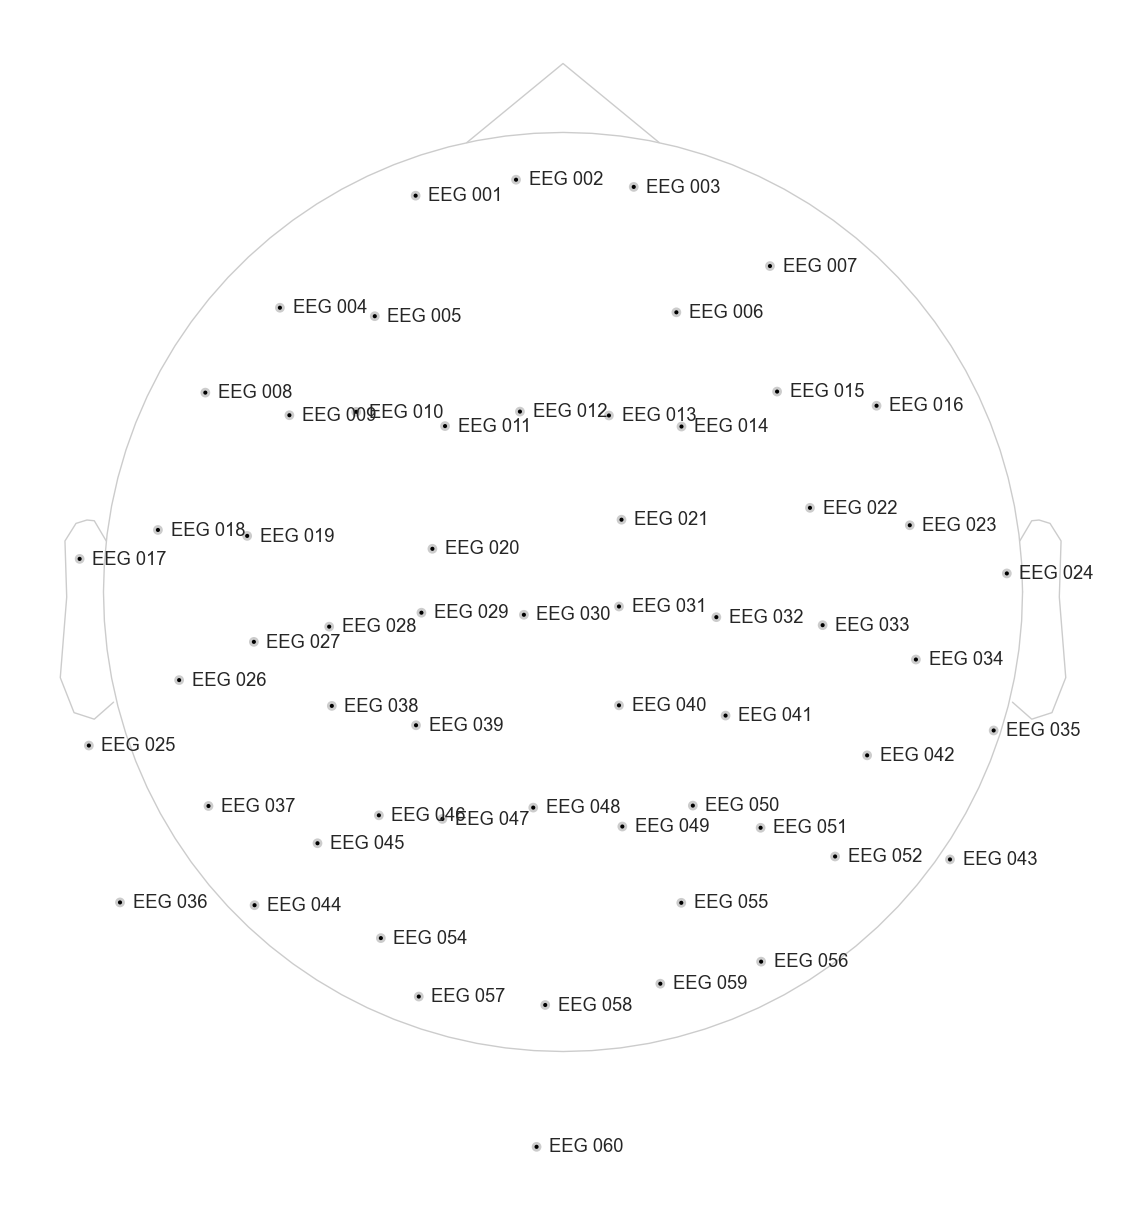

In [20]:
epochs_aud.plot_sensors(show_names=True)
plt.show()

In [13]:
# Main bands to visualize
main_bands = ['Theta', 'Alpha', 'Beta', 'Low Gamma']

In [16]:
# Select an occipital channel (strong alpha)
channel = 'EEG 060'  # Occipital
channel_idx = epochs_aud.ch_names.index(channel)

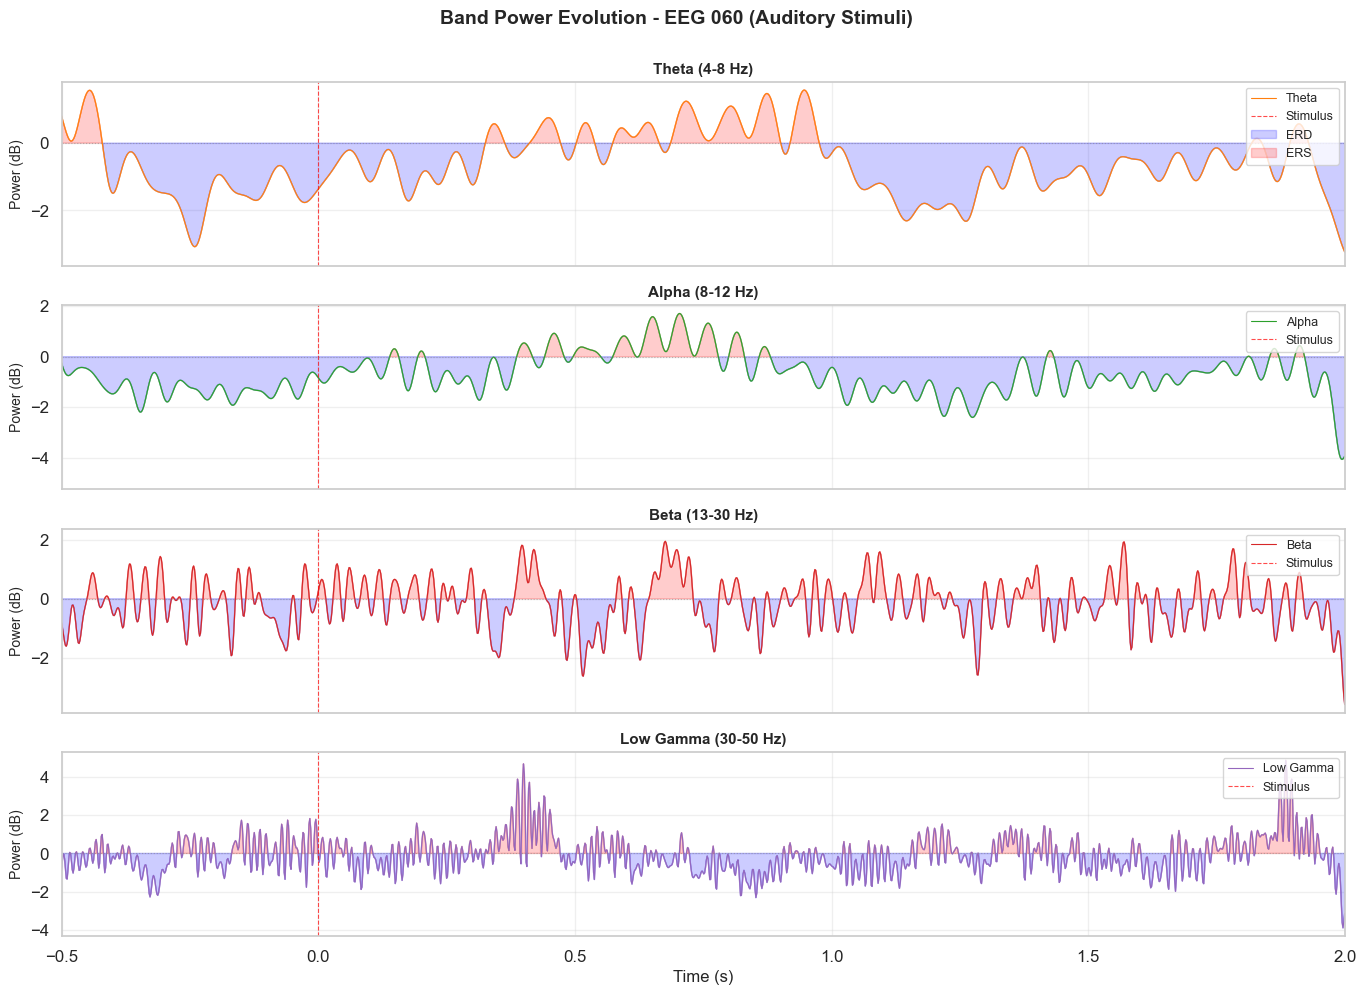

In [19]:
# Compute band power for each band
fig, axes = plt.subplots(len(main_bands), 1, figsize=(14, 10), sharex=True)

for idx, band_name in enumerate(main_bands):
    fmin, fmax = BANDS[band_name]
    
    # Compute band power
    band_power = compute_band_power(epochs_aud, band_name, fmin, fmax)
    
    # Average across epochs for this channel
    power_avg = band_power[:, channel_idx, :].mean(axis=0)
    power_sem = band_power[:, channel_idx, :].std(axis=0) / np.sqrt(len(epochs_aud))
    
    # Convert to baseline-corrected dB
    baseline_mask = (epochs_aud.times >= -1.0) & (epochs_aud.times < -0.5)
    baseline_power = power_avg[baseline_mask].mean()
    power_db = 10 * np.log10(power_avg / baseline_power)
    
    # Plot
    ax = axes[idx]
    ax.plot(epochs_aud.times, power_db, linewidth=0.8, color=BAND_COLORS[band_name], label=band_name)
    ax.fill_between(epochs_aud.times, power_db - power_sem, power_db + power_sem, alpha=0.3, color=BAND_COLORS[band_name])
    
    # Markers
    ax.axvline(0, color='red', linestyle='--', linewidth=0.8, alpha=0.7, label='Stimulus')
    ax.axhline(0, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)
    
    # Shade ERD/ERS regions
    ax.fill_between(epochs_aud.times, 0, power_db, where=(power_db < 0), alpha=0.2, color='blue', label='ERD' if idx == 0 else '')
    ax.fill_between(epochs_aud.times, 0, power_db, where=(power_db > 0), alpha=0.2, color='red', label='ERS' if idx == 0 else '')
    
    # Formatting
    ax.set_ylabel('Power (dB)', fontsize=10)
    ax.set_title(f'{band_name} ({fmin}-{fmax} Hz)', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xlim([-0.5, 2.0])

axes[-1].set_xlabel('Time (s)', fontsize=12)

plt.suptitle(f'Band Power Evolution - {channel} (Auditory Stimuli)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


### 6. Alpha Rhythm: The Idling Rhythm

The **alpha rhythm** (8-12 Hz) is one of the most studied brain oscillations:

**Characteristics**:
- **Strongest** over occipital cortex (visual areas)
- **Increases** when eyes are closed (visual cortex "idling")
- **Decreases** during visual attention (alpha ERD)
- Thought to reflect **cortical inhibition**

**The Alpha Paradox**:
- High alpha = **Inhibited** or idling state
- Low alpha (ERD) = **Active** processing

In [25]:
# Compare alpha power in occipital vs frontal channels
channels_to_compare = {
    'Occipital (Visual)': 'EEG 060',  # Strong alpha
    'Frontal (Executive)': 'EEG 011',  # Weaker alpha
    'Central (Motor)': 'EEG 030',      # Mu rhythm (motor alpha)
}


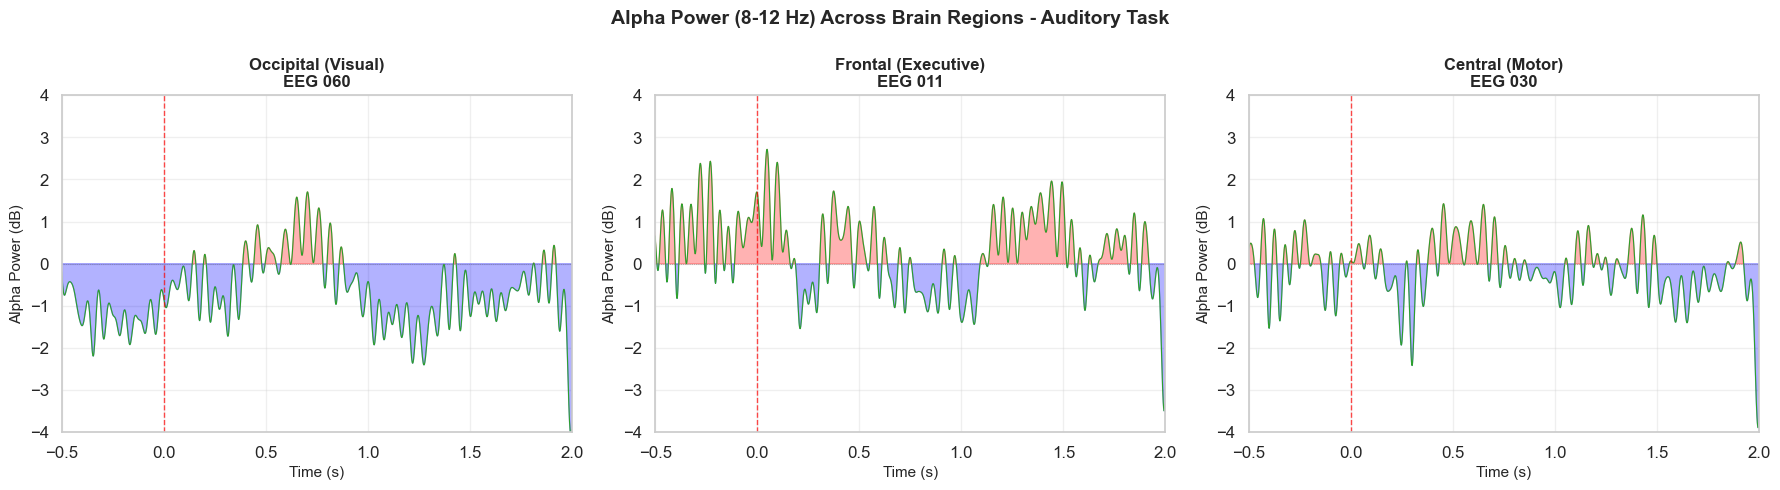

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (region_name, channel) in zip(axes, channels_to_compare.items()):
    channel_idx = epochs_aud.ch_names.index(channel)
    
    # Compute alpha power
    alpha_power = compute_band_power(epochs_aud, 'Alpha', 8, 12)
    power_avg = alpha_power[:, channel_idx, :].mean(axis=0)
    
    # Baseline correction
    baseline_mask = (epochs_aud.times >= -1.0) & (epochs_aud.times < -0.5)
    baseline = power_avg[baseline_mask].mean()
    power_db = 10 * np.log10(power_avg / baseline)
    
    # Plot
    ax.plot(epochs_aud.times, power_db, linewidth=0.8, color=BAND_COLORS['Alpha'])
    ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.axhline(0, color='gray', linestyle=':', linewidth=0.5)
    ax.fill_between(epochs_aud.times, 0, power_db,where=(power_db < 0), alpha=0.3, color='blue')
    ax.fill_between(epochs_aud.times, 0, power_db,where=(power_db > 0), alpha=0.3, color='red')
    
    ax.set_xlabel('Time (s)', fontsize=11)
    ax.set_ylabel('Alpha Power (dB)', fontsize=11)
    ax.set_title(f'{region_name}\n{channel}', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_xlim([-0.5, 2.0])
    ax.set_ylim([-4, 4])

plt.suptitle('Alpha Power (8-12 Hz) Across Brain Regions - Auditory Task', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Alpha Power Dynamics (8–12 Hz)**

We see clear regional specialization:

- **Frontal Executive (EEG 011)**: This region shows the most sustained alpha synchronization (red areas). This suggests high cognitive control or "top-down" inhibition, where the brain is likely suppressing irrelevant information to focus on the auditory stimulus.

- **Occipital Visual (EEG 060)**: In contrast, the back of the brain shows alpha desynchronization (blue areas). This is known as "alpha blocking," which indicates that the visual cortex is moving from a resting state to an alert state, even if the stimulus is sound rather than sight.

- **Central Motor (EEG 030)**: This area remains the most stable, suggesting that the "Mu rhythm" (central alpha) isn't heavily engaged, which is consistent with a task that doesn't require a physical motor response.

### 7. Beta Rhythm: Motor Control and Cognition

The **beta rhythm** (13-30 Hz) is associated with:

**Motor Functions**:
- **Beta ERD**: During movement preparation and execution
- **Beta Rebound (ERS)**: After movement completion (motor cortex resetting)
- Strong over sensorimotor cortex

**Cognitive Functions**:
- Active thinking and concentration
- Top-down control
- Maintaining current state

In [27]:
# Focus on central electrodes (motor cortex)
motor_channels = ['EEG 034', 'EEG 030', 'EEG 026']  # Central electrodes

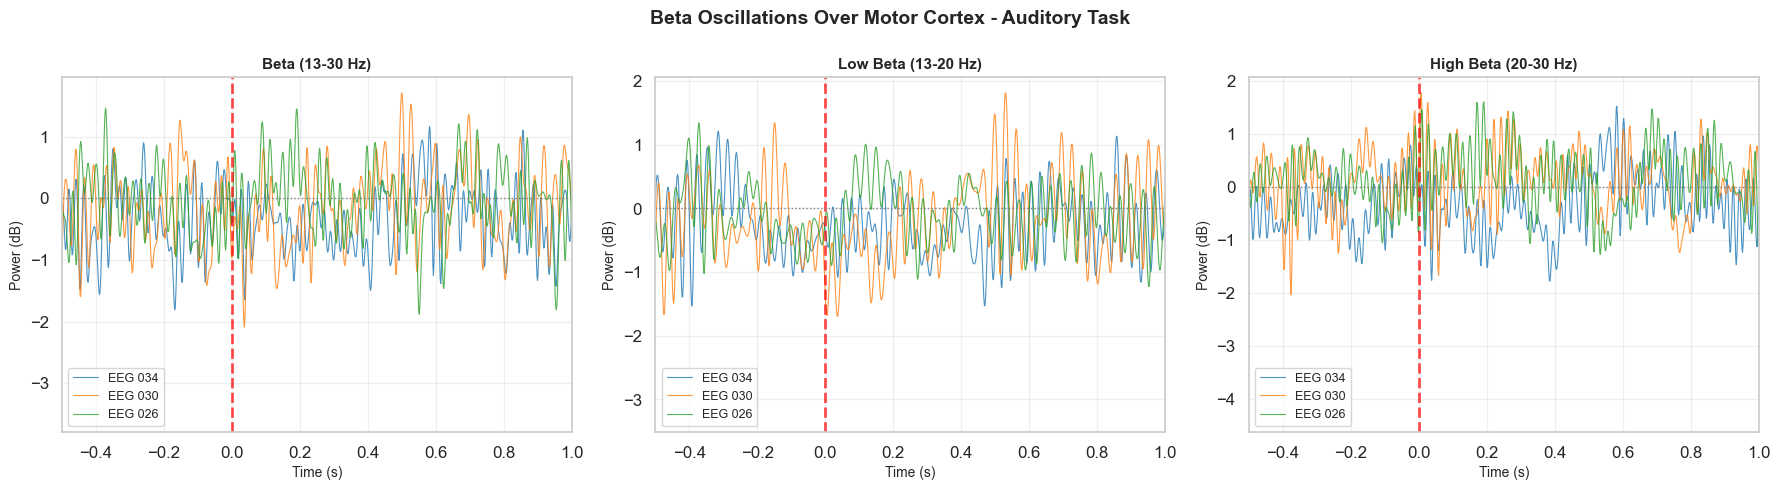

In [32]:
# Compute beta power for each motor channel
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.ravel()

# Compare low vs high beta
beta_bands = {
    'Beta (13-30 Hz)': (13, 30),
    'Low Beta (13-20 Hz)': (13, 20),
    'High Beta (20-30 Hz)': (20, 30),
}

for idx, (band_name, (fmin, fmax)) in enumerate(beta_bands.items()):
    ax = axes[idx]
    
    for channel in motor_channels:
        channel_idx = epochs_aud.ch_names.index(channel)
        
        # Compute band power
        band_power = compute_band_power(epochs_aud, band_name, fmin, fmax)
        power_avg = band_power[:, channel_idx, :].mean(axis=0)
        
        # Baseline correction
        baseline_mask = (epochs_aud.times >= -1.0) & (epochs_aud.times < -0.5)
        baseline = power_avg[baseline_mask].mean()
        power_db = 10 * np.log10(power_avg / baseline)
        
        # Plot
        ax.plot(epochs_aud.times, power_db, linewidth=0.8, label=channel, alpha=0.8)
    
    ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.set_ylabel('Power (dB)', fontsize=10)
    ax.set_title(f'{band_name}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([-0.5, 1.0])


plt.suptitle('Beta Oscillations Over Motor Cortex - Auditory Task', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Beta Oscillations over Motor Cortex (13–30 Hz)**

- **Beta Suppression**: Immediately following the stimulus ($t = 0.0$s), there is a noticeable dip in power across all three beta sub-bands. This is a typical "event-related desynchronization" (ERD), indicating that the motor cortex is becoming more active or alert in response to the sound.

- **High vs. Low Beta**: The High Beta (20–30 Hz) shows more rapid, high-amplitude fluctuations compared to the Low Beta (13–20 Hz). This often reflects a distinction between simple motor preparation (low beta) and more complex cognitive "status quo" maintenance or alertness (high beta).

- **Channel Consistency**: All three central channels track very closely together, confirming that the motor cortex is reacting as a unified functional unit during this task.

### 8. Gamma Rhythm: Attention and Binding

**Gamma oscillations** (30-100 Hz) are associated with:

**Cognitive Functions**:
- **Attention**: Selective focus and concentration
- **Binding**: Integrating features into coherent percepts
- **Consciousness**: Gamma may be a signature of awareness
- **Local processing**: Usually confined to specific brain regions

**Characteristics**:
- Brief bursts rather than sustained
- Often phase-locked to slower rhythms (theta-gamma coupling)
- Metabolically expensive

Gamma is divided into:
- **Low gamma** (30-50 Hz): More common, broader functions
- **High gamma** (50-100 Hz): More focal, task-specific

In [33]:
# Analyze gamma for visual vs auditory stimuli
epochs_vis = epochs['visual']

In [34]:
gamma_bands = {
    'Low Gamma (30-50 Hz)': (30, 50),
    'High Gamma (50-100 Hz)': (50, 100),
}

stimulus_types = {
    'Auditory': epochs_aud,
    'Visual': epochs_vis,
}
  

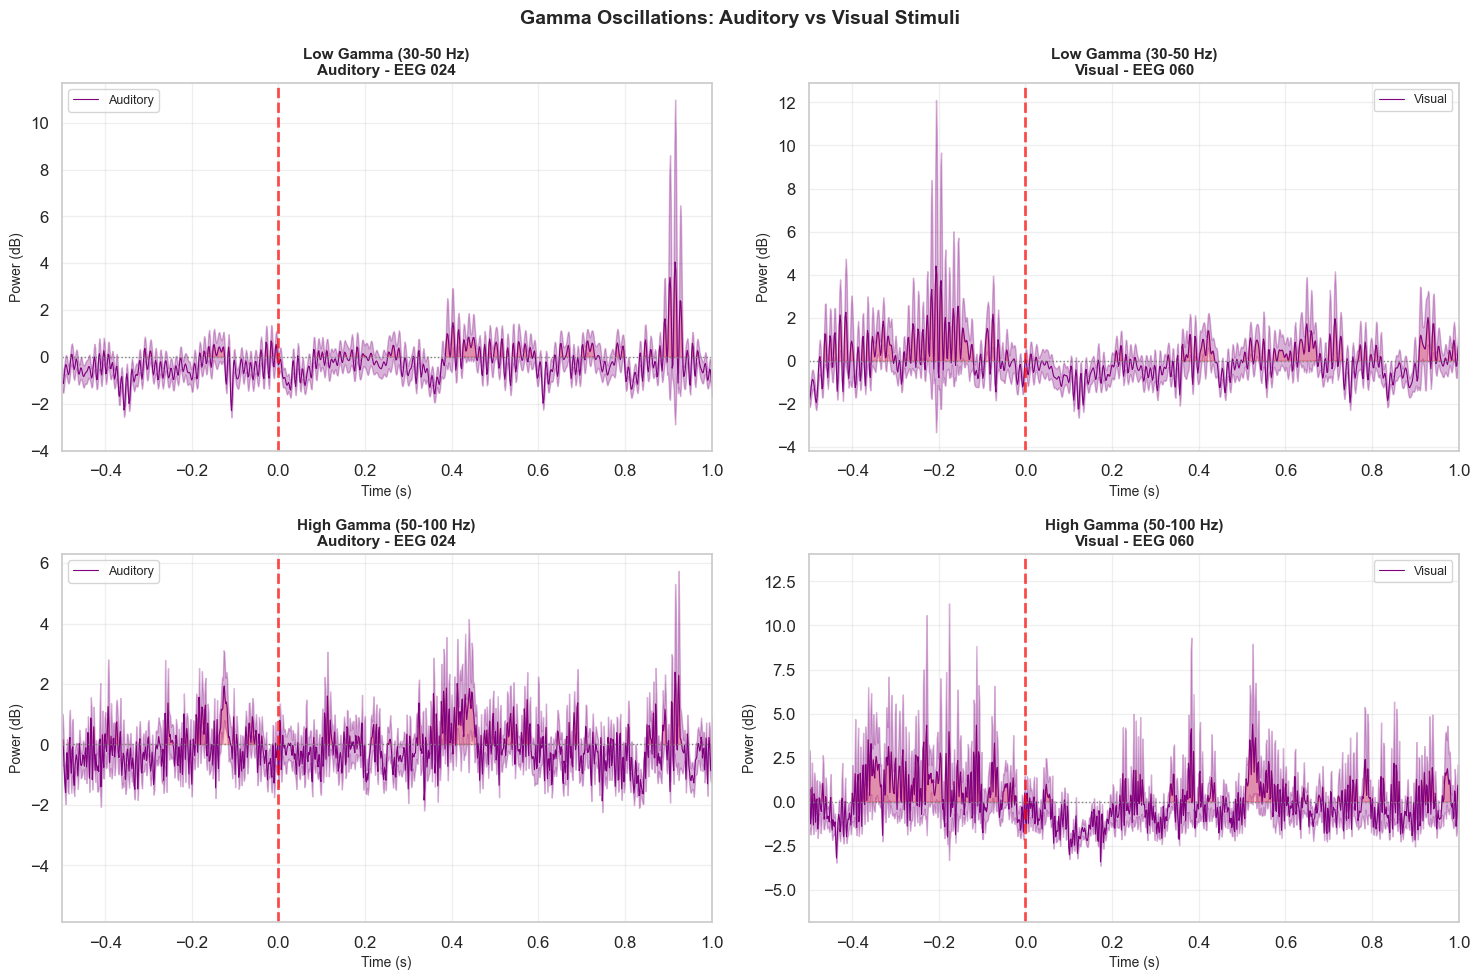

In [38]:
# Compare gamma response to different stimuli
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for row, (gamma_name, (fmin, fmax)) in enumerate(gamma_bands.items()):
    for col, (stim_name, epochs_stim) in enumerate(stimulus_types.items()):
        ax = axes[row, col]
        
        # Select appropriate channel
        channel = 'EEG 060' if stim_name == 'Visual' else 'EEG 024'
        channel_idx = epochs_stim.ch_names.index(channel)
        
        # Compute gamma power
        gamma_power = compute_band_power(epochs_stim, gamma_name, fmin, fmax)
        
        # Average across epochs
        power_avg = gamma_power[:, channel_idx, :].mean(axis=0)
        power_sem = gamma_power[:, channel_idx, :].std(axis=0) / np.sqrt(len(epochs_stim))
        
        # Baseline correction
        baseline_mask = (epochs_stim.times >= -1.0) & (epochs_stim.times < -0.5)
        baseline = power_avg[baseline_mask].mean()
        power_db = 10 * np.log10(power_avg / baseline)
        sem_db = 10 * power_sem / (baseline * np.log(10))
        
        # Plot
        ax.plot(epochs_stim.times, power_db, linewidth=0.8, color='purple', label=f'{stim_name}')
        ax.fill_between(epochs_stim.times, power_db - sem_db, power_db + sem_db, alpha=0.3, color='purple')
        
        ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax.axhline(0, color='gray', linestyle=':', linewidth=1)
        ax.fill_between(epochs_stim.times, 0, power_db, where=(power_db > 0), alpha=0.2, color='red')
        
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel('Power (dB)', fontsize=10)
        ax.set_title(f'{gamma_name}\n{stim_name} - {channel}', fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.set_xlim([-0.5, 1.0])
        ax.legend(fontsize=9)

plt.suptitle('Gamma Oscillations: Auditory vs Visual Stimuli', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Gamma Oscillations (30–100 Hz): Auditory vs. Visual**

The most striking observation from is the difference in timing and intensity of High-Frequency activity:

- **Visual Gamma (EEG 060)**: Shows a massive burst of Low Gamma (30–50 Hz) power immediately preceding the onset of the stimulus. This likely reflects rapid sensory anticipation or initial registration in the primary visual cortex.

- **Auditory Gamma (EEG 024)**: The response is much more delayed and "late-stage." Significant spikes in both Low and High Gamma power occur after the stimulus. This suggests that for this auditory task, high-frequency "binding" or complex processing happens much later than the initial sensory input.

### 9. Time-Frequency Analysis: All Bands Together

Let's use time-frequency analysis to see all bands simultaneously and understand their interactions.

In [39]:
# Compute full time-frequency representation
freqs = np.logspace(np.log10(4), np.log10(80), num=40)  # 4 to 80 Hz
n_cycles = freqs / 2.0  # Adaptive cycles

power_tfr = tfr_morlet(
    epochs_aud, freqs=freqs, n_cycles=n_cycles,
    use_fft=True, return_itc=False,
    average=True, verbose=False
)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


In [40]:
# Plot for occipital channel
channel = 'EEG 060'
channel_idx = power_tfr.ch_names.index(channel)

# Apply baseline correction
power_tfr_baseline = power_tfr.copy()
power_tfr_baseline.apply_baseline(baseline=(-1.0, -0.5), mode='logratio')

# Extract data
tfr_data = power_tfr_baseline.data[channel_idx, :, :]

Applying baseline correction (mode: logratio)


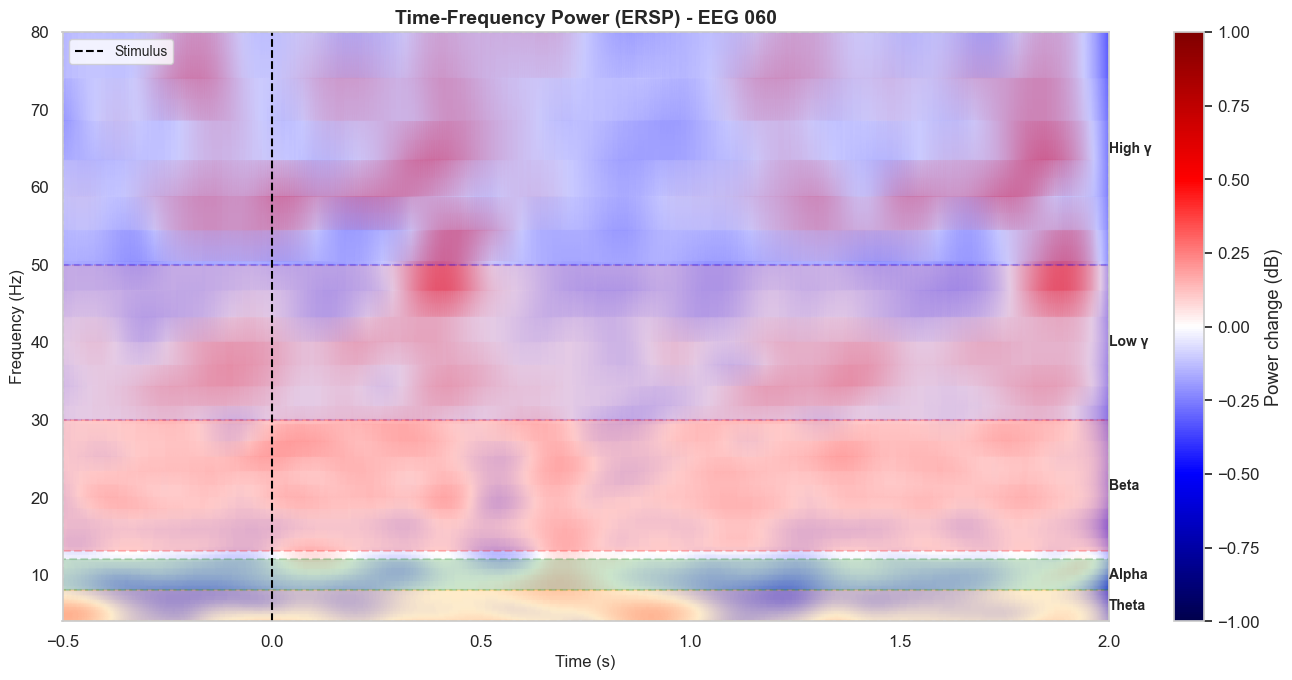

In [67]:
# Create figure with band boundaries
fig, ax = plt.subplots(figsize=(14, 7))

im = ax.pcolormesh(power_tfr.times, freqs, tfr_data, shading='gouraud', cmap='seismic', vmin=-1, vmax=1)

# Add frequency band boundaries
band_boundaries = [
    ('Theta', 4, 8, 'orange'),
    ('Alpha', 8, 12, 'green'),
    ('Beta', 13, 30, 'red'),
    ('Low γ', 30, 50, 'purple'),
    ('High γ', 50, 80, 'blue'),
]

for band_name, fmin, fmax, color in band_boundaries:
    ax.axhspan(fmin, fmax, alpha=0.2, color=color, linewidth=1.5, linestyle='--')
    ax.text(2, (fmin + fmax) / 2, band_name, fontsize=10, fontweight='bold', va='center')

ax.axvline(0, color='black', linestyle='--', linewidth=1.5, label='Stimulus')
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Frequency (Hz)', fontsize=12)
ax.set_title(f'Time-Frequency Power (ERSP) - {channel}', fontsize=14, fontweight='bold')
ax.set_xlim([-0.5, 2.0])
ax.legend(loc='upper left', fontsize=10)

cbar = plt.colorbar(im, ax=ax, label='Power change (dB)')

plt.tight_layout()
plt.show()

### 10. Statistical Analysis

Let's perform statistical tests to determine which time-frequency points show significant power changes.

In [69]:
# Compute TFR for individual epochs (don't average yet)
power_tfr_single = tfr_morlet(
    epochs_aud, freqs=freqs, n_cycles=n_cycles,
    use_fft=True, return_itc=False,
    average=False, verbose=False
)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


In [77]:
# Select channel
channel = 'EEG 060'
channel_idx = power_tfr_single.ch_names.index(channel)

In [78]:
# Extract and Baseline (per epoch)
tfr_data_epochs = power_tfr_single.data[:, channel_idx, :, :]
baseline_mask = (power_tfr_single.times >= -1.0) & (power_tfr_single.times < -0.5)
baseline_power = tfr_data_epochs[:, :, baseline_mask].mean(axis=2, keepdims=True)
tfr_ersp = 10 * np.log10(tfr_data_epochs / baseline_power)
tfr_mean = tfr_ersp.mean(axis=0)

In [79]:
# Statistical Testing (t-test + FDR Correction)

from statsmodels.stats.multitest import multipletests


t_vals, p_vals = np.zeros(tfr_mean.shape), np.zeros(tfr_mean.shape)
for f in range(len(freqs)):
    for t in range(len(power_tfr_single.times)):
        t_vals[f, t], p_vals[f, t] = stats.ttest_1samp(tfr_ersp[:, f, t], 0)

reject, p_corrected, _, _ = multipletests(p_vals.flatten(), alpha=0.05, method='fdr_bh')
reject = reject.reshape(p_vals.shape)

In [80]:
# Create Masked ERSP: Hides non-significant noise
tfr_masked = np.ma.masked_where(~reject, tfr_mean)

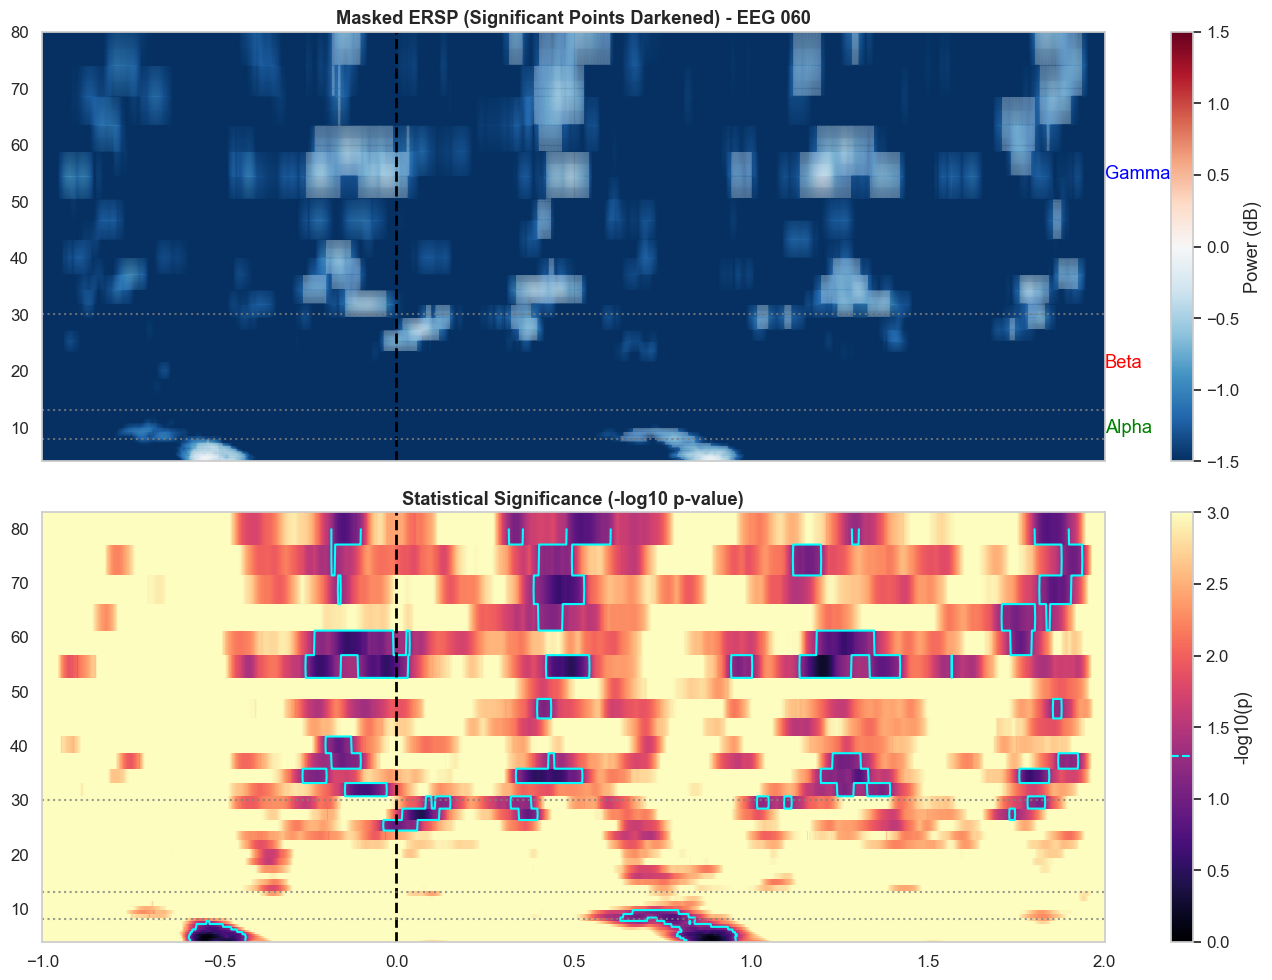

In [90]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top Plot: Mean ERSP with Significance Masking
axes[0].pcolormesh(power_tfr_single.times, freqs, tfr_mean, shading='gouraud', cmap='RdBu_r', vmin=-1.5, vmax=1.5, alpha=0.2)
im1 = axes[0].pcolormesh(power_tfr_single.times, freqs, tfr_masked, shading='gouraud', cmap='RdBu_r', vmin=-1.5, vmax=1.5)

# Bottom Plot: High-Contrast Significance
p_plot_data = -np.log10(p_corrected.reshape(len(freqs), -1))
im2 = axes[1].pcolormesh(power_tfr_single.times, freqs, p_plot_data, shading='auto', cmap='magma', vmin=0, vmax=3)
axes[1].contour(power_tfr_single.times, freqs, reject.astype(int), levels=[0.5], colors='cyan', linewidths=1.5)

band_info = [('Alpha', 8, 12, 'green'), ('Beta', 13, 30, 'red'), ('Gamma', 30, 80, 'blue')]

for ax in axes:
    ax.axvline(0, color='black', linestyle='--', linewidth=2)
    for name, fmin, fmax, col in band_info:
        ax.axhline(fmin, color='gray', alpha=0.8, linestyle=':')
        if ax == axes[0]:
            ax.text(2, (fmin+fmax)/2, name, color=col, va='center') 

axes[0].set_title(f'Masked ERSP (Significant Points Darkened) - {channel}', fontweight='bold')
axes[1].set_title('Statistical Significance (-log10 p-value)', fontweight='bold')

plt.colorbar(im1, ax=axes[0], label='Power (dB)')

cbar2 = plt.colorbar(im2, ax=axes[1], label='-log10(p)')
cbar2.ax.axhline(-np.log10(0.05), color='cyan', linestyle='--')

plt.tight_layout()
plt.show()

In [84]:
print("Statistical Testing:")
print(f"• Total time-frequency points: {len(freqs) * len(power_tfr_single.times)}")
print(f"• Significant points (FDR p<0.05): {reject.sum()}")
print(f"• Percentage significant: {100 * reject.sum() / reject.size:.1f}%")
print("\nCyan contours show significant regions (FDR corrected p < 0.05)")

Statistical Testing:
• Total time-frequency points: 72120
• Significant points (FDR p<0.05): 68189
• Percentage significant: 94.5%

Cyan contours show significant regions (FDR corrected p < 0.05)


- **Cyan Contours**: These highlight the specific "islands" of time and frequency where the brain’s response is most reliable. You can see significant clusters in the Beta and Gamma ranges, confirming that these high-frequency changes are true biological responses to the task.

### 11. Compare Oscillations Across Conditions

Let's directly compare oscillatory responses between auditory and visual stimuli.

In [91]:
# Compute TFR for visual stimuli
power_tfr_vis = tfr_morlet(
    epochs_vis, freqs=freqs, n_cycles=n_cycles,
    use_fft=True, return_itc=False,
    average=True, verbose=False
)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


In [92]:
# Apply baseline
power_tfr_vis.apply_baseline(baseline=(-1.0, -0.5), mode='logratio')

Applying baseline correction (mode: logratio)


Data type,Average Power Estimates
Data source,Epochs
Number of epochs,59
Dims,"channel, freq, time"
Estimation method,morlet
Number of channels,59
Number of timepoints,1803
Number of frequency bins,40
Frequency range,4.00 – 80.00 Hz


In [94]:
# Select channels: occipital for visual, temporal for auditory
channels_comparison = {
    'Auditory': ('EEG 026', power_tfr_baseline),  # Temporal
    'Visual': ('EEG 060', power_tfr_vis),         # Occipital
}

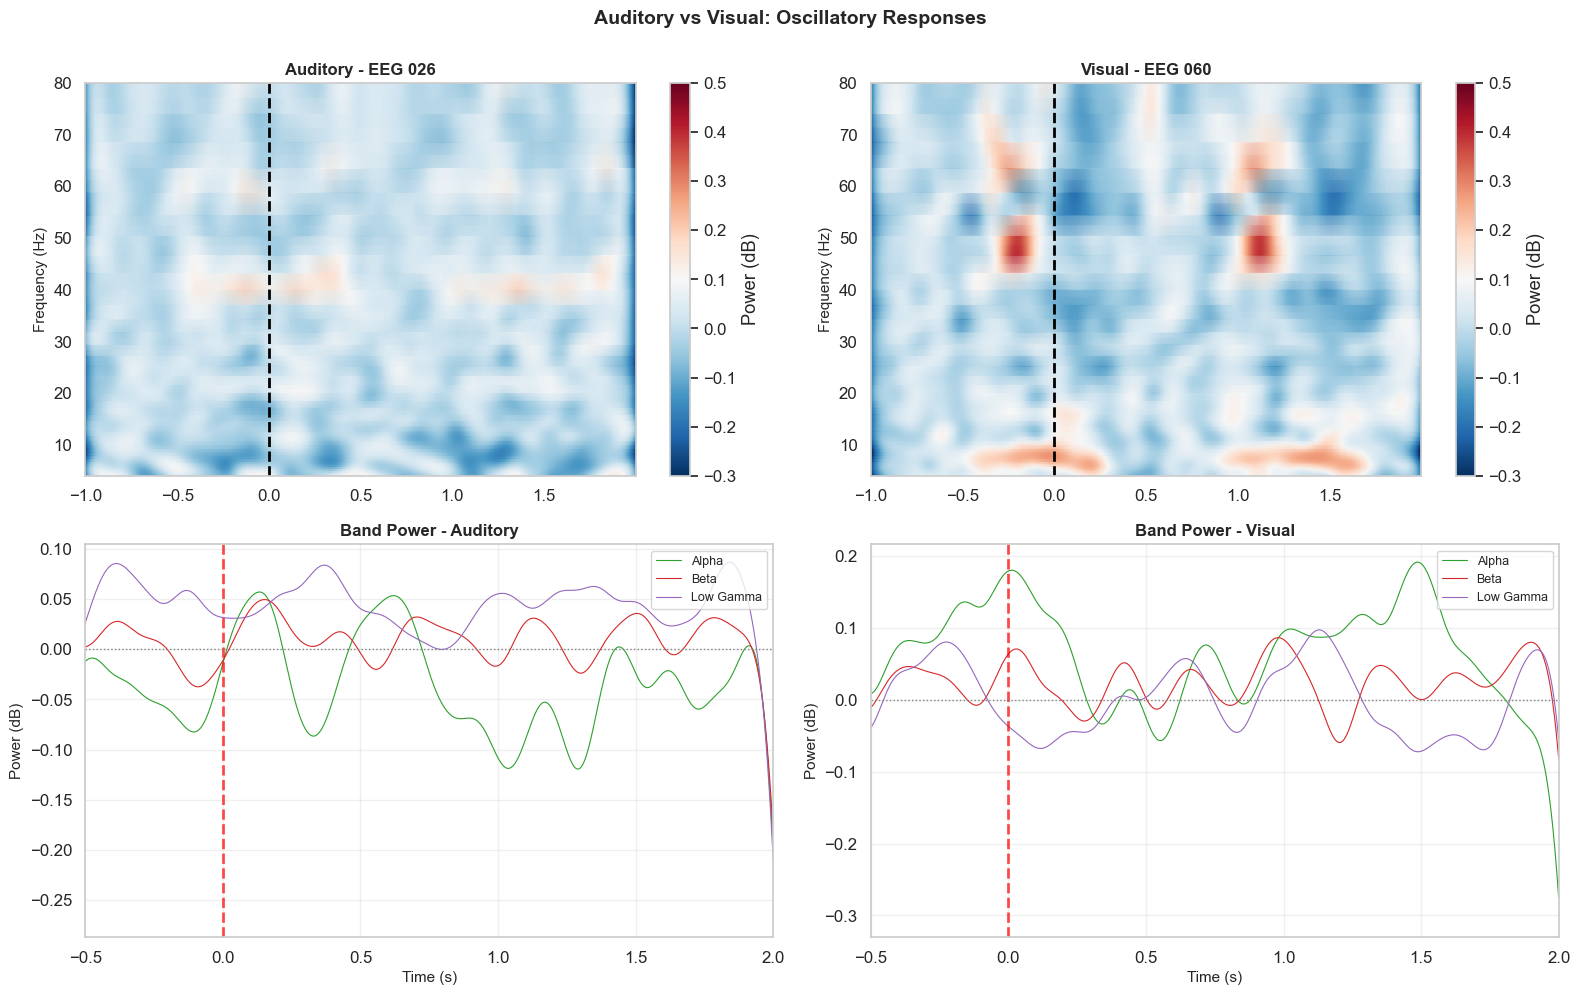

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for col, (condition, (channel, tfr_data)) in enumerate(channels_comparison.items()):
    channel_idx = tfr_data.ch_names.index(channel)
    data = tfr_data.data[channel_idx, :, :]
    
    ax1 = axes[0, col]
    im1 = ax1.pcolormesh(tfr_data.times, freqs, data, shading='gouraud', cmap='RdBu_r', vmin=-0.3, vmax=0.5)
    ax1.axvline(0, color='black', linestyle='--', linewidth=2)
    ax1.set_ylabel('Frequency (Hz)', fontsize=11)
    ax1.set_title(f'{condition} - {channel}', fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=ax1, label='Power (dB)')
    
    # Bottom row: Band-specific time courses
    ax2 = axes[1, col]
    
    bands_to_plot = ['Alpha', 'Beta', 'Low Gamma']
    for band_name in bands_to_plot:
        fmin, fmax = BANDS[band_name]
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        band_power = data[freq_mask, :].mean(axis=0)
        
        ax2.plot(tfr_data.times, band_power, linewidth=0.8, label=band_name, color=BAND_COLORS[band_name])
    
    ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax2.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax2.set_xlabel('Time (s)', fontsize=11)
    ax2.set_ylabel('Power (dB)', fontsize=11)
    ax2.set_title(f'Band Power - {condition}', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9, loc='upper right')
    ax2.grid(alpha=0.3)
    ax2.set_xlim([-0.5, 2.0])

plt.suptitle('Auditory vs Visual: Oscillatory Responses', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 12. Topographic Analysis: Where Do Rhythms Live?

Different frequency bands have characteristic spatial distributions. Let's visualize where each rhythm is strongest.

In [103]:
# Compute power spectral density for resting baseline period
# Use the pre-stimulus period as "resting" state
epochs_baseline = epochs.copy().crop(tmin=-1.0, tmax=-0.5)

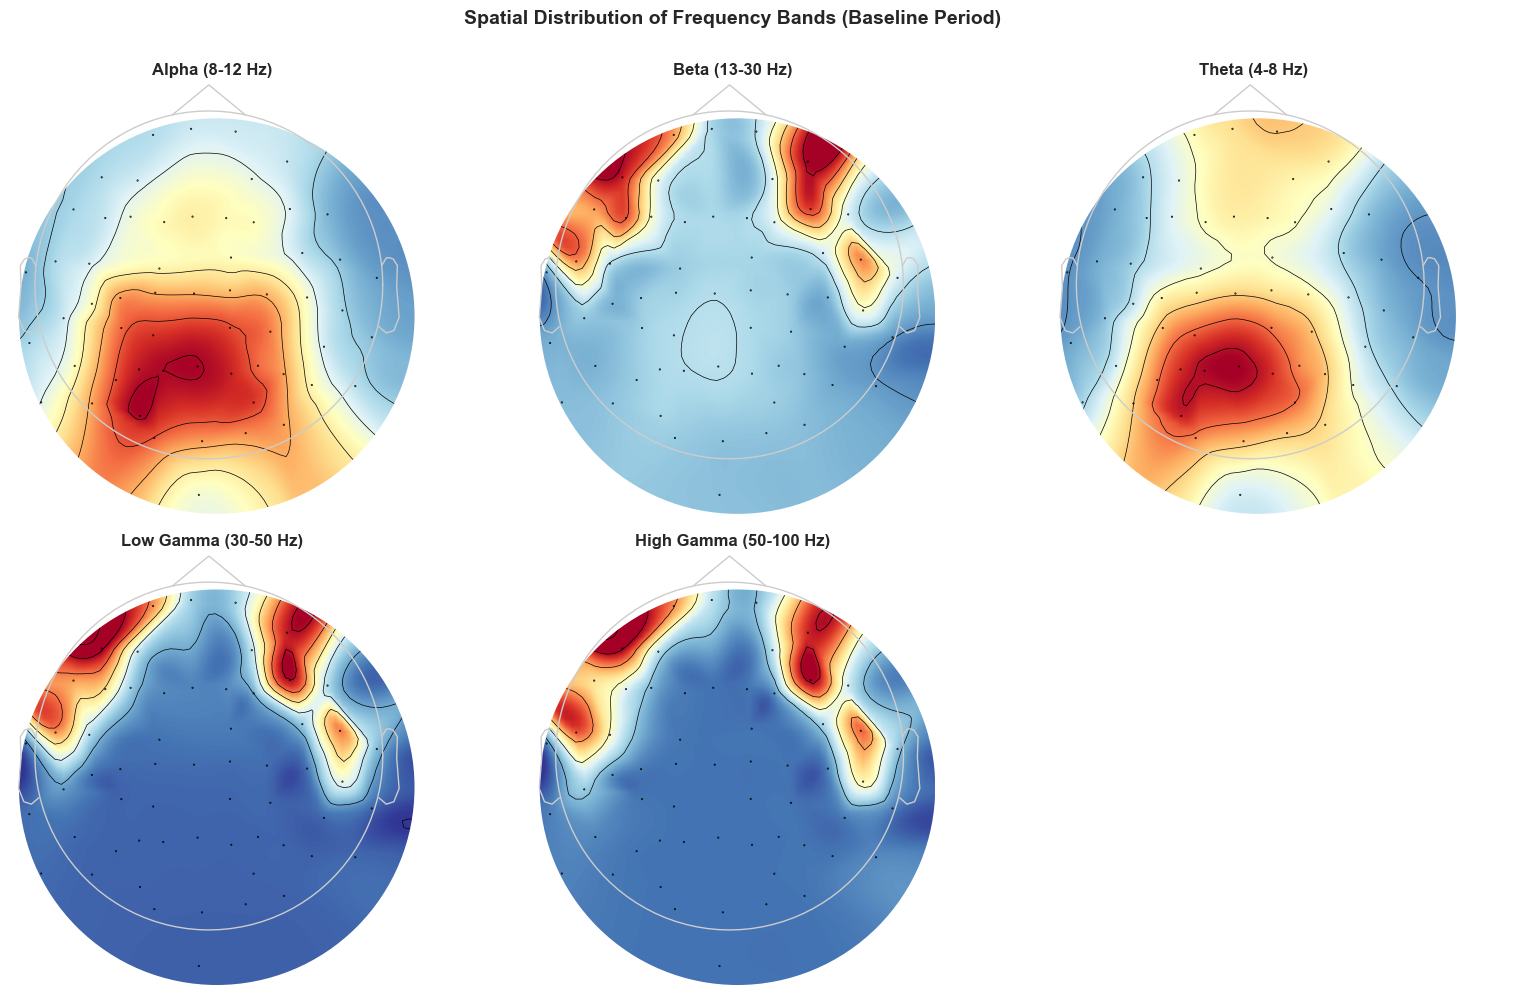

In [104]:
# Compute PSD for each band
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

main_bands_topo = ['Alpha', 'Beta', 'Theta', 'Low Gamma', 'High Gamma']

for idx, band_name in enumerate(main_bands_topo):
    if idx >= len(axes):
        break
        
    ax = axes[idx]
    fmin, fmax = BANDS[band_name]
    
    # Compute power spectrum
    spectrum = epochs_baseline.compute_psd(
        method='welch',
        fmin=fmin, fmax=fmax,
        verbose=False
    )
    
    # Average across frequency bins in this band
    spectrum_data = spectrum.get_data().mean(axis=-1)  # Average across frequencies
    band_power_avg = spectrum_data.mean(axis=0)  # Average across epochs
    
    # Create topomap
    im, _ = mne.viz.plot_topomap(
        band_power_avg,
        spectrum.info,
        axes=ax,
        show=False,
        cmap='RdYlBu_r',
        contours=6
    )
    
    ax.set_title(f'{band_name} ({fmin}-{fmax} Hz)', 
                 fontsize=12, fontweight='bold')

# Remove empty subplot
axes[-1].axis('off')

plt.suptitle('Spatial Distribution of Frequency Bands (Baseline Period)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

#### Alpha (8-12 Hz) & Theta (4-8 Hz)
- **Observation**: Both bands show a massive "hotspot" (dark red) in the Occipital and Parietal regions (back of the head).
- **Interpretation**: This is a very healthy resting-state signature. Alpha is most dominant at the back of the brain when a person is relaxed. High Theta in these same regions during baseline can indicate a state of calm or readiness before a task starts.

#### Beta (13-30 Hz)
- **Observation**: The red "hotspots" shift away from the back and move toward the Frontal and Temporal regions (the sides and front).
- **Interpretation**: Higher Beta power in the frontal areas during baseline often reflects an "active" idling state, your executive brain is alert and waiting for the stimulus.

#### Low Gamma (30-50 Hz) & High Gamma (50-100 Hz)
- **Observation**: These high-frequency bands show very specific, localized activity in the Temporal lobes (the sides of the head, near the ears).
- **Interpretation**: Since gamma oscillations are linked to sensory processing, having high baseline gamma in the temporal regions suggests those areas are highly "primed" and ready to receive the upcoming auditory information.